<a href="https://www.kaggle.com/code/elena0606/progect-3-ne?scriptVersionId=96690088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. ПОДГОТОВКА РАБОЧЕГО ПРОСТРАНСТВА

### Загружаем необходимые библиотеки

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from collections import Counter
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Data collection

In [4]:
# Подгрузим наши данные из соревнования ../input/sf-booking

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [5]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# 2. Data preporation

### Создаем новый датасет с информацией об отеле

In [6]:
# Признаки, характеризующие отель, а не отзыв
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']
hotels = data[hotel_cols].drop_duplicates().reset_index(drop=True)
hotels['hotel_id'] = hotels.index

# Добавляем к основному датасету ID отеля, убираем признаки, относящиеся к отелю, из основного дата-сета
data = data.merge(hotels, on=hotel_cols, how='left')
data = data.drop(hotel_cols, axis=1)

# 3. EDA

## FEATURE ENGINEERING

### Извлечение признаков из адреса отеля

In [7]:
# Выделяем страну, город и почтовый индекс из адреса отеля
# Добавляем население города (https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits)

hotels['city'] = hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
hotels['country'] = hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
hotels['zip'] = hotels.hotel_address.apply(lambda x: x.split()[-4] + ' ' + x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])

сity_population = {
    'Paris': 2165423, 'London': 9002488, 'Milan': 1374582, 
    'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 821752
}
hotels['сity_population'] = hotels['city'].map(сity_population)

country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
hotels['country_population'] = hotels['country'].map(country_population)

hotels['%_city_pop_from_country_pop'] = hotels['сity_population'] / hotels['country_population']

hotels.head(2)


,hotel_name,hotel_address,lat,lng,average_score,total_number_of_reviews,additional_number_of_scoring,hotel_id,city,country,zip,сity_population,country_population,%_city_pop_from_country_pop
0,Hotel Da Vinci,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,8.1,16670,904,0,Milan,Italy,20161,1374582,60313823,0.022790
1,Urban Lodge Hotel,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,8.6,5018,612,1,Amsterdam,Netherlands,1043 EW,821752,17198147,0.047781


In [8]:
hotels.groupby('country')['hotel_name'].count()


country
Austria           158
France            458
Italy             162
Netherlands       105
Spain             211
United Kingdom    400
Name: hotel_name, dtype: int64

In [9]:
pd.DataFrame(data['reviewer_nationality'].value_counts())

,reviewer_nationality
United Kingdom,245246
United States of America,35437
Australia,21686
Ireland,14827
United Arab Emirates,10235
...,...
Comoros,1
Anguilla,1
Tuvalu,1
Cape Verde,1


In [10]:
# распределение отелей по странам
fig=plt.figure(figsize=(10,6))
df_h = hotels.groupby('country')['hotel_name'].count()
fig = px.choropleth(
    locations=df_h.index,
    locationmode = "country names",
    scope='europe',
    color=np.log(df_h.values),
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

# распределение гостей по странам (по национальностям)
df_c = pd.DataFrame(data['reviewer_nationality'].value_counts())
fig = px.choropleth(
    locations=df_c.index,
    locationmode = "country names",
    color=np.log(df_c['reviewer_nationality']),
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

<Figure size 720x432 with 0 Axes>

In [11]:
geo=hotels
i=geo[geo.lat.isnull()].index
len(i)
geo=geo.drop(i,axis=0)

In [12]:
# Создаем датасет с иноформацией о средней географической координате каждго почтового индекса для последующего заполнения пропусков
geo = geo.groupby(['city', 'zip']).agg({'lat': 'mean', 'lng': 'mean'})#reset_index()
hotels = hotels.merge(geo, on=['city', 'zip'], suffixes=('', '_avg'))

In [13]:
# Заменяем пропущенные координаты значениями, вычисленными по почтовому индексу
hotels['lat'] = np.where(hotels.lat.isna(), hotels.lat_avg, hotels.lat)
hotels['lng'] = np.where(hotels.lng.isna(), hotels.lng_avg, hotels.lng)
hotels = hotels.drop(['lat_avg', 'lng_avg'], axis=1)
#hotels.head(3)

### Извлечение признаков из даты отзыва

In [14]:
# Добавляем признак давности размещения отзыва и месяца
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['days_since_review'] = (data['review_date'].max() - data['review_date']).dt.days#/np.timedelta64(1,'D')).astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)
data['dayofweek'] = data['review_date'].dt.dayofweek
data['weekend'] = data['dayofweek'].apply(lambda x: 0 if x < 5 else 1)
data = data.drop(['review_date'], axis=1)
#data.head(2)

In [15]:
# Оставлю только 10 наиболее активных национальностей
most_active_nationalities= data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x:x if x in most_active_nationalities else 'Other')
data['reviewer_nationality'] = LabelEncoder().fit_transform(data['reviewer_nationality'])

### Разбор тэгов

In [16]:
#Преобразуем теги в списки
hotels['tags']= data.tags.apply(lambda x: x[3:-3].split(" ', ' "))
tag=hotels['tags'].explode().value_counts()

In [17]:
# продолжительность пребывания
def night_number(col):
    for tag in col:
        if tag.split(' ')[0] == 'Stayed':
            return int(tag.split(' ')[1])
hotels['night_number'] = hotels['tags'].apply(night_number)
hotels['night_number'] = hotels['night_number'].fillna(hotels['night_number'].median())
hotels['night_number'] = hotels['night_number'].apply(lambda x: x if x <= 7 else 10)

In [18]:
# тип комнаты
def room_type(col):
    for tag in col:
        if tag.split(' ')[-1] == 'Room':
            return tag#[:-4]
hotels['room_type'] = hotels['tags'].apply(room_type)

room_type =(hotels['room_type'].value_counts(normalize=True).nlargest(10))
hotels['room_type'] = hotels['room_type'].apply(lambda x: x.strip() if x in room_type else 'other')
#room_type

In [19]:
# теги описание поездки
conditions = ['Couple','Solo traveler','Business trip','Family with young children','Group','Family with older children','With a pet']

hotels['Couple']=''
hotels['Solo traveler']=''
hotels['Business trip']=''
hotels['Family with young children'] = ''
hotels['Group']=''
hotels['Family with older children']=''
hotels['With a pet']=''

for col in hotels[conditions].columns:
    hotels[col]=hotels['tags'].apply(lambda x: 1 if col in x else 0)

In [20]:
# количество тегов
hotels['tags_length'] = hotels['tags'].apply(lambda x: len(x))

In [21]:
tag.drop(room_type.index,inplace=True)
tag.drop([i  for i in tag.index if (i.split(' ')[0] == 'Stayed')],inplace=True)
tag.drop([i  for i in tag.index if (i.split(' ')[-1] == 'Room')],inplace=True)
tag.drop([i  for i in tag.index if i in conditions],inplace=True)
s=set(tag.index)-set(room_type.index)
#len(s)

In [22]:
#t_i=list(s)[:6]
t_i=tag.index[:2]
for i in t_i:
    hotels[i]=''
for col in hotels[t_i].columns:
    hotels[col]=hotels['tags'].apply(lambda x:1 if col in x else 0)

In [23]:
data = data.drop(['tags'], axis=1)
data = data.merge(hotels, on='hotel_id', how='left')

In [24]:
# Кодируем зип с помощью LabelEncoder
data['zip'] = LabelEncoder().fit_transform(data['zip'])
data['city'] = LabelEncoder().fit_transform(data['city'])
data['country'] = LabelEncoder().fit_transform(data['country'])
data['room_type'] = LabelEncoder().fit_transform(data['room_type'])
# топ 50
hotel_name_list =(data['hotel_name'].value_counts(normalize=True).nlargest(50))
data['hotel_name'] = data['hotel_name'].apply(lambda x: x.strip() if x in hotel_name_list else 'other') 
data['hotel_name'] = LabelEncoder().fit_transform(data['hotel_name'])
# Кодируем город с помощью dummies
#data = pd.get_dummies(data, columns=['city'])

#data.info()


### Разбор отзывов на слова и выделение топ встречающихся по позитивным и негативным отзывам

In [25]:
data['new_positive_review']=data['positive_review']
data['new_positive_review']=data['new_positive_review'].fillna('')
data['new_negative_review']=data['negative_review']
data['new_negative_review']=data['new_negative_review'].fillna('')
#создаем признаки со списками слов после очистки в отзывах
data['pos_words']=data['new_positive_review'].apply(lambda x: x.split())
data['neg_words']=data['new_negative_review'].apply(lambda x: x.split())

# создаем общие списки негативных и позитивных слов
array = data['neg_words'].explode()
neg_counter = Counter(array)
neg_top = neg_counter.most_common(200)
neg_words = set(dict(neg_top))

array = data['pos_words'].explode()
pos_counter = Counter(array)
pos_top = pos_counter.most_common(200)
pos_words = set(dict(pos_top))

#создаем уникальные списки слов (без встречающихся и среди негативных и среди позитивных)
true_neg = neg_words - pos_words
true_pos = pos_words - neg_words
#счетчик количества позитивных слов в обоих типах отзывах
def num_pos_words(col):
    count = 0
    for word in col:
        if word in true_pos:
            count += 1
    return count
data['pos_words_in_pos_rev'] = data['pos_words'].apply(num_pos_words)
data['pos_words_in_neg_rev'] = data['neg_words'].apply(num_pos_words)


#счетчик количества негативных слов в обоих типах отзывах
def num_neg_words(col):
    count = 0
    for word in col:
        if word in true_neg:
            count += 1
    return count
data['neg_words_in_neg_rev'] = data['neg_words'].apply(num_neg_words)
data['neg_words_in_pos_rev'] = data['pos_words'].apply(num_neg_words)

In [26]:
# отношение количества позитивных и негативных слов к общей длине отзывов
data['pos_word_per_pos_rev'] = data['pos_words_in_pos_rev']/data['review_total_positive_word_counts']
data['neg_word_per_pos_rev'] = data['neg_words_in_pos_rev']/data['review_total_positive_word_counts']
data['pos_word_per_neg_rev'] = data['pos_words_in_neg_rev']/data['review_total_negative_word_counts']
data['neg_word_per_neg_rev'] = data['neg_words_in_neg_rev']/data['review_total_negative_word_counts']

data['pos_word_per_pos_rev'] = data['pos_word_per_pos_rev'].fillna(0)
data['neg_word_per_pos_rev'] = data['neg_word_per_pos_rev'].fillna(0)
data['pos_word_per_neg_rev'] = data['pos_word_per_neg_rev'].fillna(0)
data['neg_word_per_neg_rev'] = data['neg_word_per_neg_rev'].fillna(0)

data['pos_word_per_pos_rev'] = data['pos_word_per_pos_rev'].apply(lambda x: 0 if x == float("inf") else x )
data['neg_word_per_pos_rev'] = data['neg_word_per_pos_rev'].apply(lambda x: 0 if x == float("inf") else x )
data['pos_word_per_neg_rev'] = data['pos_word_per_neg_rev'].apply(lambda x: 0 if x == float("inf") else x )
data['neg_word_per_neg_rev'] = data['neg_word_per_neg_rev'].apply(lambda x: 0 if x == float("inf") else x )

### Анализ тональности с помощью Vader nltk.sentiment.vader

In [27]:
analyz = SentimentIntensityAnalyzer()

data['negative_review_analyze'] = data['negative_review'].apply(lambda x: analyz.polarity_scores(x))
data['positive_review_analyze'] = data['positive_review'].apply(lambda x: analyz.polarity_scores(x))

data.loc[:,['neg_rev_neg_mood_score', 'neg_rev_neutral_mood_score','neg_rev_pos_mood_score','neg_rev_mood_score']] = list(data['negative_review_analyze'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['pos_rev_neg_mood_score', 'pos_rev_neutral_mood_score','pos_rev_pos_mood_score','pos_rev_mood_score']] = list(data['positive_review_analyze'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

## Нормализация данных

array([[<AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'neg_rev_neutral_mood_score'}>,
        <AxesSubplot:title={'center':'neg_rev_pos_mood_score'}>],
       [<AxesSubplot:title={'center':'neg_rev_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_neg_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_pos_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_mood_score'}>],
       [<AxesSubplot:title={'center':'pos_words_in_neg_rev'}>,
        <AxesSubplot:title={'center':'neg_words_in_pos_rev'}>,
        <AxesSubplot:title={'center':'pos_words_in_pos_

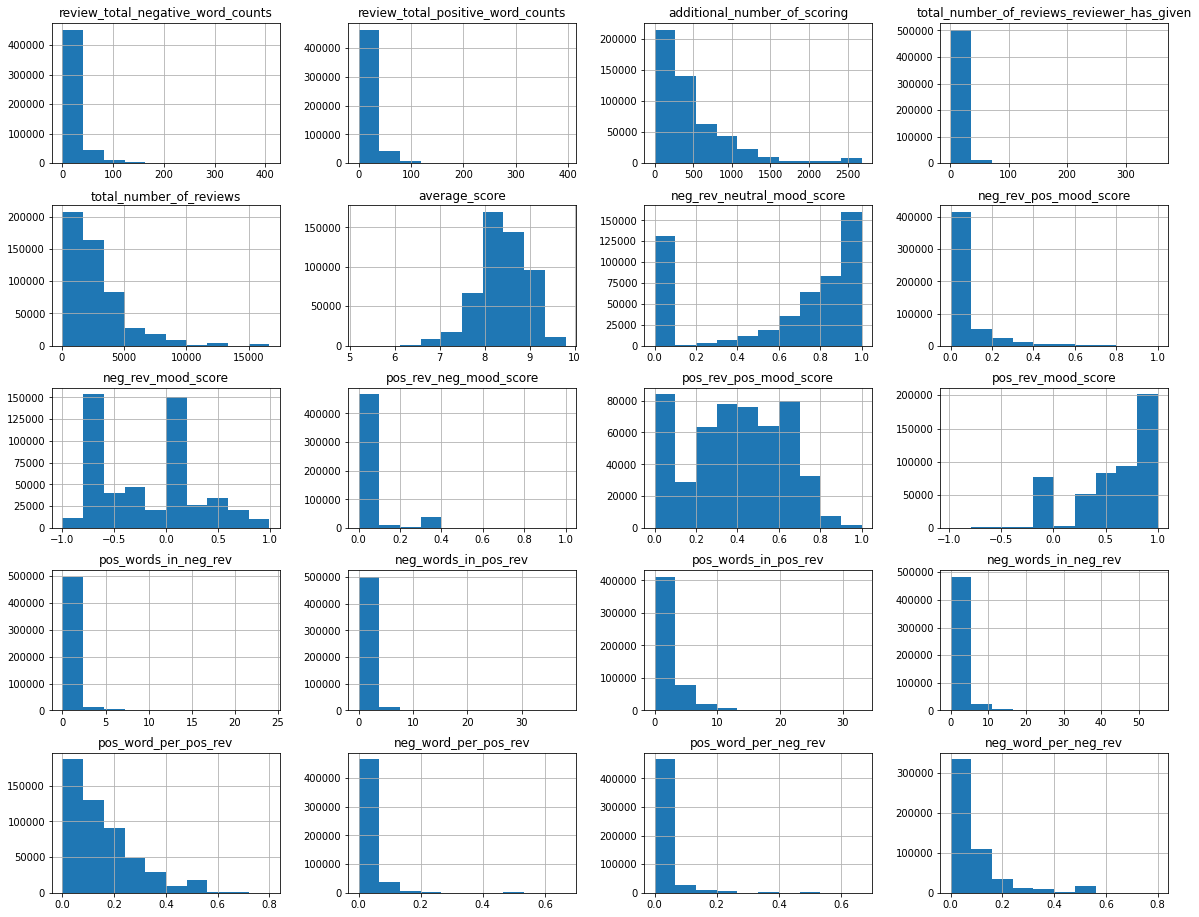

In [28]:
# список численных признаков
num_cols = ['review_total_negative_word_counts',
            'review_total_positive_word_counts',
            'additional_number_of_scoring',
            'total_number_of_reviews_reviewer_has_given', 
            'total_number_of_reviews',
            'average_score',
            'neg_rev_neutral_mood_score',
            'neg_rev_pos_mood_score',
            'neg_rev_mood_score',
            'pos_rev_neg_mood_score',
            'pos_rev_pos_mood_score',
            'pos_rev_mood_score',
            'pos_words_in_neg_rev',
            'neg_words_in_pos_rev',
            'pos_words_in_pos_rev',
            'neg_words_in_neg_rev',
            'pos_word_per_pos_rev',
            'neg_word_per_pos_rev',
            'pos_word_per_neg_rev',
            #'days_since_review ',
            'neg_word_per_neg_rev'
                        ]
data[num_cols].hist(figsize=(20, 16))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([[<AxesSubplot:title={'center':'review_total_negative_word_counts'}>,
        <AxesSubplot:title={'center':'review_total_positive_word_counts'}>,
        <AxesSubplot:title={'center':'additional_number_of_scoring'}>,
        <AxesSubplot:title={'center':'total_number_of_reviews_reviewer_has_given'}>],
       [<AxesSubplot:title={'center':'total_number_of_reviews'}>,
        <AxesSubplot:title={'center':'average_score'}>,
        <AxesSubplot:title={'center':'neg_rev_neutral_mood_score'}>,
        <AxesSubplot:title={'center':'neg_rev_pos_mood_score'}>],
       [<AxesSubplot:title={'center':'neg_rev_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_neg_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_pos_mood_score'}>,
        <AxesSubplot:title={'center':'pos_rev_mood_score'}>],
       [<AxesSubplot:title={'center':'pos_words_in_neg_rev'}>,
        <AxesSubplot:title={'center':'neg_words_in_pos_rev'}>,
        <AxesSubplot:title={'center':'pos_words_in_pos_

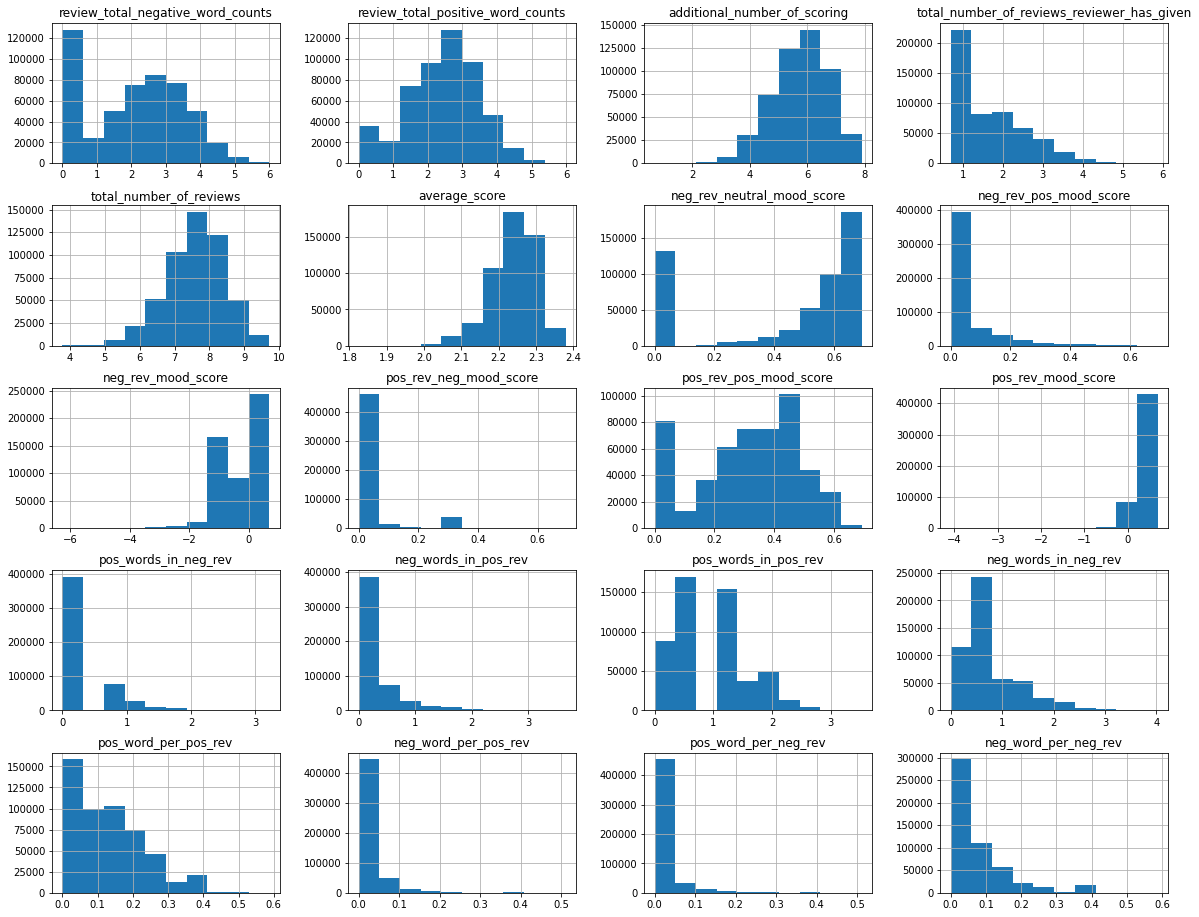

In [29]:
for i in num_cols:
    #print(i)
    data[i] = np.log(data[i]+1)
    x=data[i]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    cleaned=x[(x>lower_bound) & (x < upper_bound)].mean()
    data[(x<lower_bound) | (x > upper_bound)][i]=cleaned
data[num_cols].hist(figsize=(20, 16))    

## Очистка данных

In [30]:
data.hotel_id

0           0
1           1
2           2
3           3
4           4
         ... 
515733    724
515734    925
515735    271
515736    188
515737    757
Name: hotel_id, Length: 515738, dtype: int64

In [31]:
data_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(data_columns, axis = 1, inplace=True)
data.drop('hotel_id', axis = 1, inplace=True)
#data = data.fillna(0)
#data.info()

<AxesSubplot:>

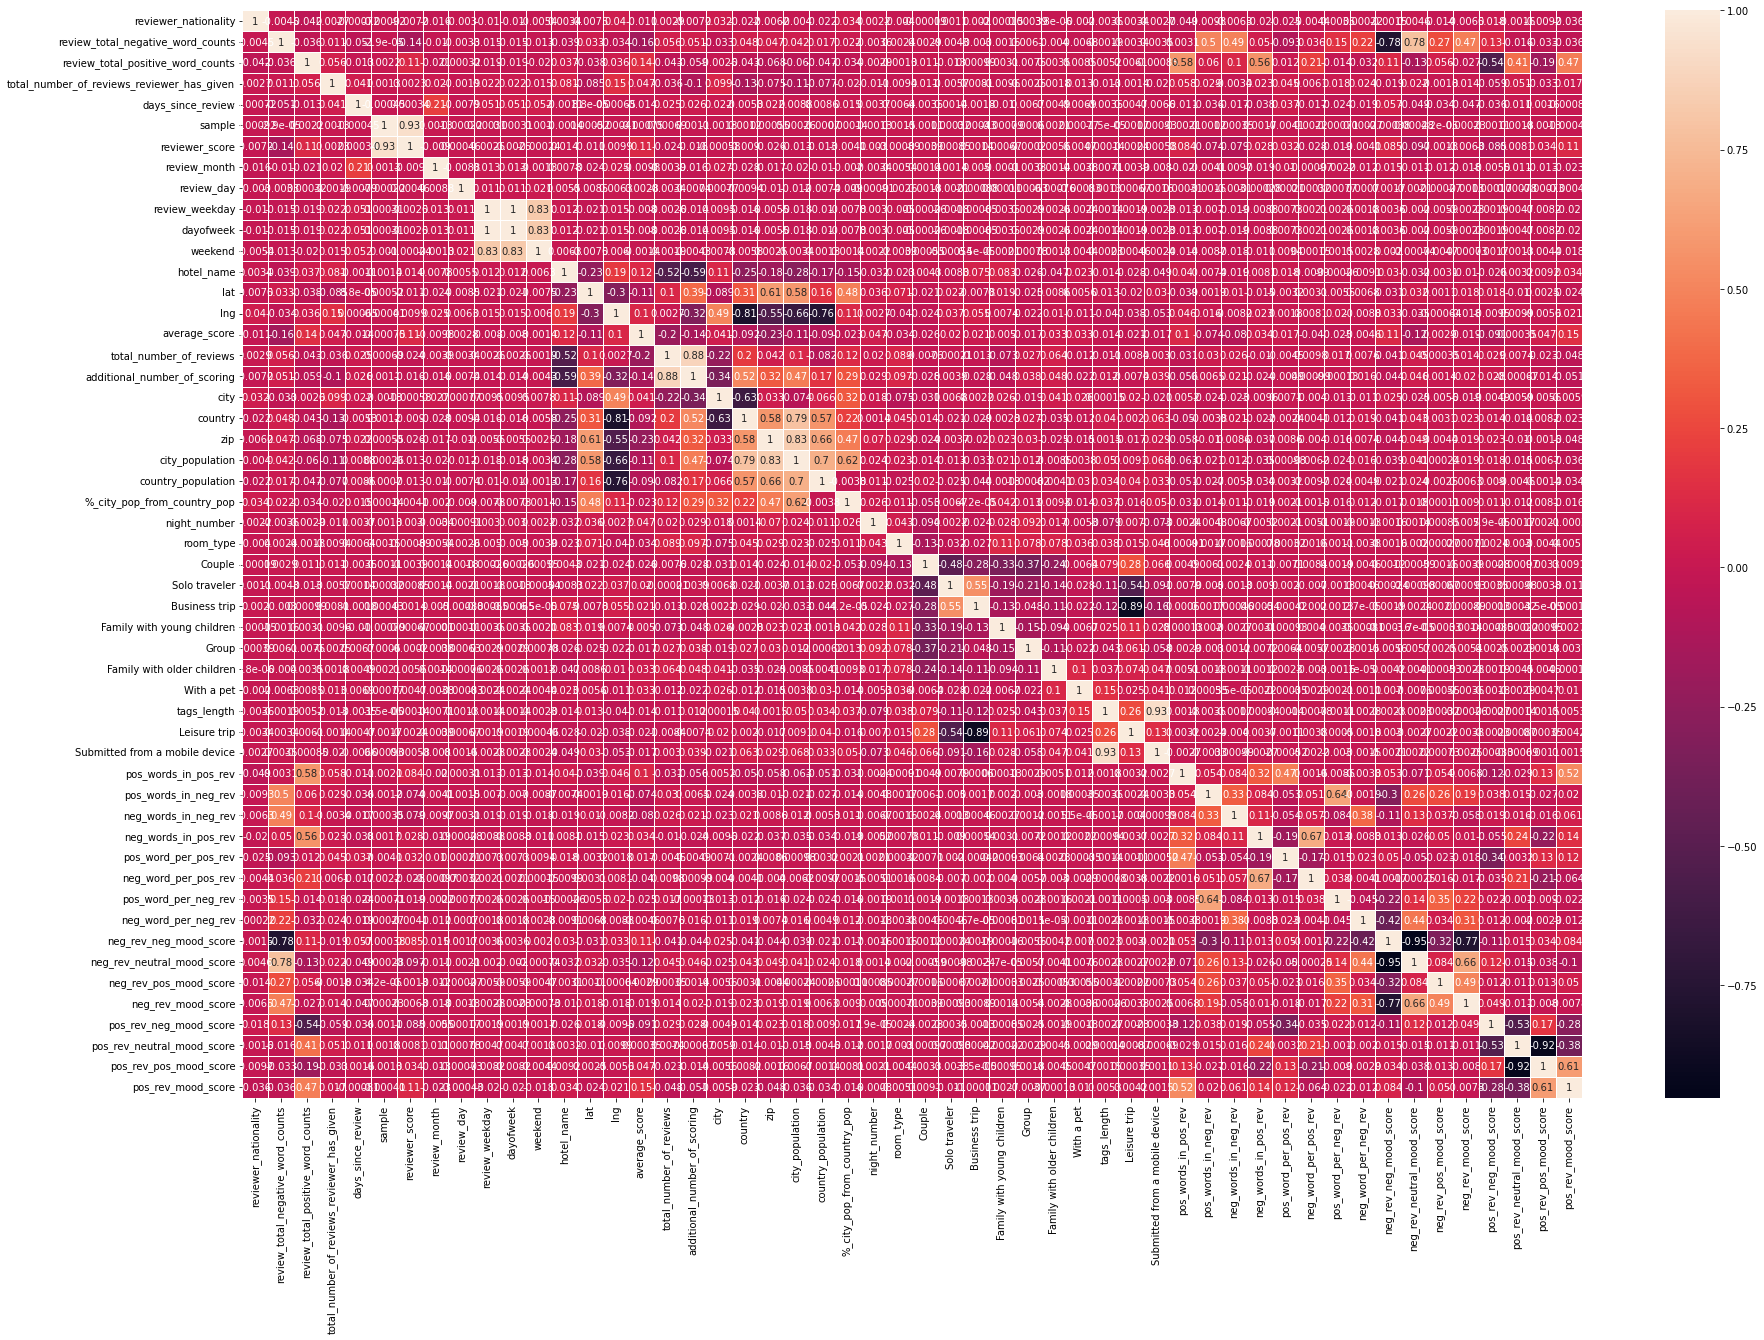

In [32]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(data.corr(), annot=True, linewidths=.5, ax=ax)

In [33]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)

In [34]:
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)


In [35]:
data1=data.copy()
pivot1=pivot.copy()

In [36]:
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show()

# постараемся удалить как можно меньше признаков. Сначала удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            print(col)
            #data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

neg_rev_neg_mood_score
tags_length
pos_rev_neutral_mood_score
Business trip
total_number_of_reviews
review_weekday
dayofweek
zip
lng
review_total_negative_word_counts
country
Deleted 11 columns


## Проверка важности признаков

In [37]:
# непрерывные признаки
num_cols = [
            #'total_number_of_reviews',
            #'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 
            'days_since_review', 
            'average_score',
            'сity_population', 'country_population', '%_city_pop_from_country_pop',
            #'neg_rev_neutral_mood_score',
            'neg_rev_pos_mood_score',
            'neg_rev_mood_score',
            #'pos_rev_neg_mood_score',
            'pos_rev_pos_mood_score',
            'pos_rev_mood_score',
            'pos_words_in_neg_rev',
            'neg_words_in_pos_rev',
            'pos_words_in_pos_rev',
            'neg_words_in_neg_rev',
            'pos_word_per_pos_rev',
            'neg_word_per_pos_rev',
            'pos_word_per_neg_rev',
            'neg_word_per_neg_rev']

# категориальные признаки
cat_cols = ['average_score', 'lat', 
            #'lng', 
            #'zip',
            #'dayofweek',
            #'hotel_id', 
            'review_month', 
            'review_day', 
            #'review_weekday',
            'reviewer_nationality',
            'weekend',
            'hotel_name',
            'city',
            'country',
            'night_number',
            'room_type',
            'Leisure trip', 'Submitted from a mobile device', 
            'Couple', 
            'Solo traveler',
            #'Business trip', 
            'Group', 'Family with older children','Family with young children', 'With a pet']     


In [38]:
hotels_selective = data.copy()
train_data = hotels_selective.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_selective.query('sample == 0').drop(['sample'], axis=1)
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'].values.astype('int')
#y=y.astype('int')      


<AxesSubplot:>

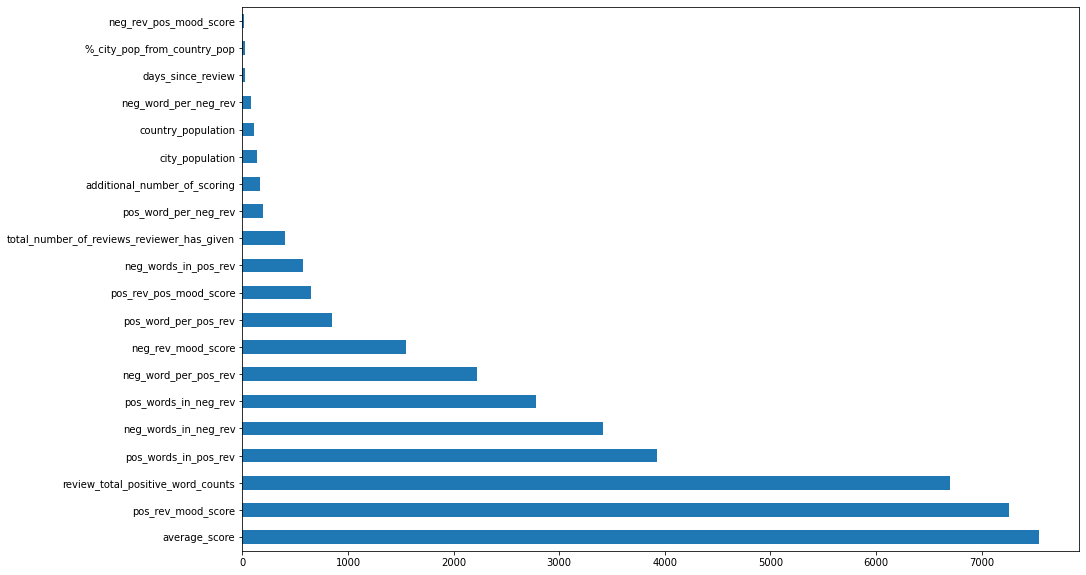

In [39]:
# числовые признаки
from sklearn.feature_selection import f_classif 
plt.rcParams['figure.figsize'] = (15,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True, ascending = False)
imp_num.plot(kind = 'barh')

In [40]:
#удаляем два самых невнятных
imoprtant_cols = []
del_num = 3
imoprtant_cols.extend(imp_num.head(len(imp_num)-del_num).index)

<AxesSubplot:>

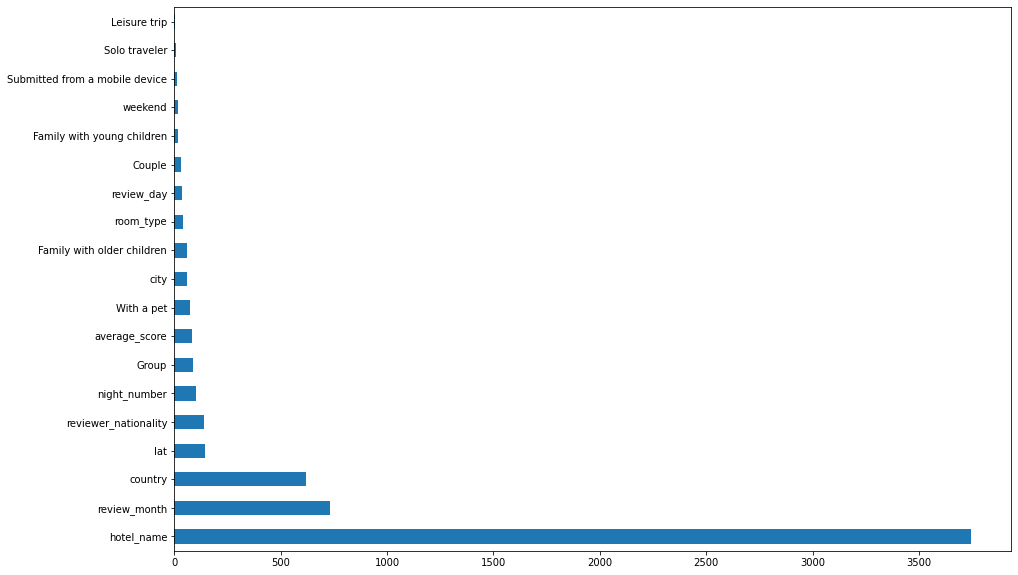

In [41]:
#категориальные признаки
from sklearn.feature_selection import chi2 # хи-квадрат
plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True, ascending = False)
imp_cat.plot(kind = 'barh')



In [42]:
#удаляем 5 невнятных
del_num = 5 
imoprtant_cols.extend(imp_cat.head(len(imp_cat)-del_num).index)
imoprtant_cols.append('reviewer_score')
imoprtant_cols.append('sample')

# Обучение модели

In [43]:
hotels_selective = data.copy()
train_data = hotels_selective.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels_selective.query('sample == 0').drop(['sample'], axis=1)
X = train_data.drop(['reviewer_score'], axis = 1)  
y = train_data['reviewer_score'].values.astype('int')

In [44]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [45]:
 #Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
#!pip install scikit-learn
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [46]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 51), (386803, 51), (386803, 50), (309442, 50), (77361, 50))

In [47]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели


In [48]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.865892297583192
MAPE: 12.286748079606378


<AxesSubplot:>

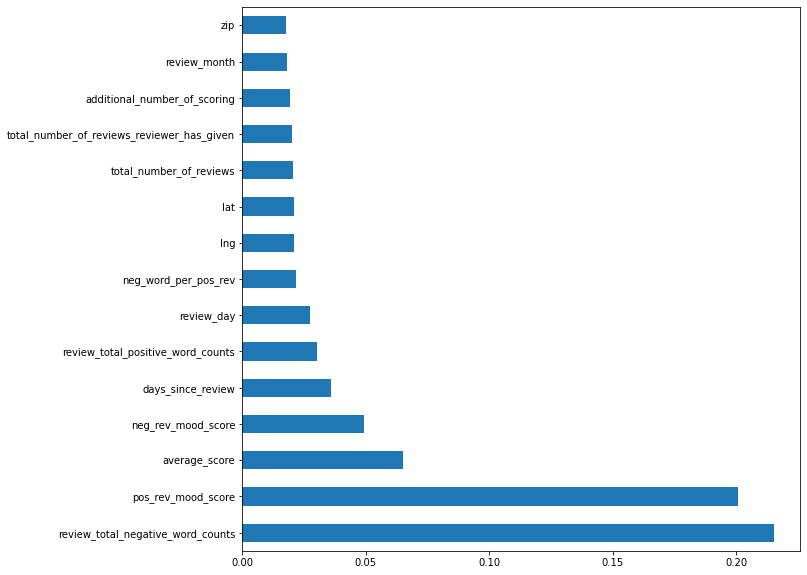

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [53]:
feat_importances.sort_values(inplace = True, ascending = False)
feat_importances*100

review_total_negative_word_counts             21.523729
pos_rev_mood_score                            20.087253
average_score                                  6.524045
neg_rev_mood_score                             4.922785
days_since_review                              3.611374
review_total_positive_word_counts              3.042889
review_day                                     2.739744
neg_word_per_pos_rev                           2.161323
lng                                            2.100979
lat                                            2.089691
total_number_of_reviews                        2.059715
total_number_of_reviews_reviewer_has_given     2.019333
additional_number_of_scoring                   1.911834
review_month                                   1.812843
zip                                            1.781689
neg_rev_neg_mood_score                         1.668652
pos_word_per_pos_rev                           1.656689
neg_word_per_neg_rev                           1

In [54]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [55]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.0s finished


In [56]:
predict_submission

array([8.767, 7.146, 8.694, ..., 8.495, 9.376, 7.664])

In [57]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.767,488440
1,7.146,274649
2,8.694,374688
3,9.661,404352
4,9.685,451596
5,8.854,302161
6,7.657,317079
7,7.404,13963
8,8.401,159785
9,7.167,195089
